## All Cancers Integration Notebook 02: Integration 

This is the Jupyter Notebook to integrate AnnData objects from all paediatric cancer datasets. As a result, an integrated AnnData object is outputted for meta analysis.

| Dataset GEO Term     | Sample Number (Patient Number) |
|----------------------|--------------------------------|
| GSE132509            | 11 (11)                        |
| GSE236351            | 7 (7)                          |
| GSE148218            | 8 (6)                          |
| GSE154109*           | 15 (15)                        |
| GSE235923            | 31 (20)                        |
| GSE235063            | 75 (28)                        |
| GSE227122            | 16 (11)                        |
| GSE102130*           | 10 (6)                         |
| GSE119926*           | 25 (25)                        |
| GSE155446/GSE156053  | 30 (28)                        |
| GSE141460            | 28 (21)                        |
| GSE189939            | 4 (4)                          |
| GSE125969/GSE126025  | 26 (26)                        |
| GSE231860/GSE231859  | 19 (19)                        |
| GSE221776            | 39 (39)                        |
| GSE198896*           | 14 (12)                        |
| GSE162454*           | 3 (3)                          |
| GSE152048*           | 6 (6)                          |
| GSE243347            | 27 (11)                        |
| GSE195709            | 4 (4)                          |
| GSE174376            | 18 (16)                        |
| EGAD00001008345*     | 28 (28)                        |
| GSE137804            | 22 (22)                        |
| GSE192906            | 10 (10)                        |
| GSE140819            | 13 (7)                         |
| GSE216176            | 17 (16)                        |
| GSE147766            | 19 (17)                        |
| PRJNA737188          | 2 (2)                          |
| GSE249995            | 4 (4)                          |
| GSE168434            | 10 (7)                         |
| GSE223373            | 3 (1)                          |

In total, there are 29/31 usuable datasets.

In [1]:
import scvi
import torch
import anndata
import glasbey
import scanpy as sc
import seaborn as sns
from rich import print

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [2]:
scvi.settings.seed = 0 # for reproducibility
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.1.2

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
# Check if GPU is detected
device_count = torch.cuda.device_count()
device_count

1

In [5]:
print(torch.cuda.is_available())

True

In [6]:
# Load the filtered, normalized, and transformed meta AnnData for bone cancer
meta_anndata_hvg = sc.read_h5ad('/scratch/user/s4543064/Xiaohan_Summer_Research/write/08_all_cancer/all_cancer_meta_anndata_hvg.h5ad')
meta_anndata_hvg

AnnData object with n_obs × n_vars = 1300958 × 559
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'disease_progression', 'sample_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'filter_rna', 'cell_type_from_paper', 'malignant_from_paper', 'age_months', 'age', 'sex', 'recurrent', 'cancer_subtype', 'metastatic'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts'

In [7]:
meta_anndata_hvg.raw.to_adata()

AnnData object with n_obs × n_vars = 1300958 × 7662
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'disease_progression', 'sample_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'filter_rna', 'cell_type_from_paper', 'malignant_from_paper', 'age_months', 'age', 'sex', 'recurrent', 'cancer_subtype', 'metastatic'
    uns: 'hvg'

The full dimension (stored in .raw) of `meta_anndata_hvg` is `n_obs × n_vars = 1300958 × 7662`

So we have 1,300,958 cells and 7,662 genes for all cancers.

In [8]:
# Double check the length of unique sample barcodes, should be 488 for all cancers
len(meta_anndata_hvg.obs['sample_barcode'].unique())

488

### <span style="color:yellow">**Integration with scVI**</span> 

In [9]:
# Set up the scVI model
scvi.model.SCVI.setup_anndata(
    meta_anndata_hvg, 
    layer="counts",
    batch_key="sample_barcode")

In [10]:
# Set the parameters for scVI
model = scvi.model.SCVI(meta_anndata_hvg, n_layers=2, n_latent=30, gene_likelihood="nb")

In [11]:
# Train the scVI model
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 6/6: 100%|████████████████████████████████████████████████████████████████| 6/6 [04:33<00:00, 45.36s/it, v_num=1, train_loss_step=399, train_loss_epoch=355]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 6/6: 100%|████████████████████████████████████████████████████████████████| 6/6 [04:33<00:00, 45.54s/it, v_num=1, train_loss_step=399, train_loss_epoch=355]


In [12]:
SCVI_LATENT_KEY = "X_scVI"
meta_anndata_hvg.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [13]:
meta_anndata_hvg

AnnData object with n_obs × n_vars = 1300958 × 559
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'disease_progression', 'sample_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'filter_rna', 'cell_type_from_paper', 'malignant_from_paper', 'age_months', 'age', 'sex', 'recurrent', 'cancer_subtype', 'metastatic', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'counts'

In [14]:
# Save the batch corrected meta adata
meta_anndata_hvg.write_h5ad('/scratch/user/s4543064/Xiaohan_Summer_Research/write/08_all_cancer/all_cancer_meta_anndata_scVI.h5ad', compression='gzip')

In [15]:
# Double check the saved scVI-corrected meta AnnData
meta_anndata_scVI = anndata.read_h5ad('/scratch/user/s4543064/Xiaohan_Summer_Research/write/08_all_cancer/all_cancer_meta_anndata_scVI.h5ad')
meta_anndata_scVI

AnnData object with n_obs × n_vars = 1300958 × 559
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'disease_progression', 'sample_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'filter_rna', 'cell_type_from_paper', 'malignant_from_paper', 'age_months', 'age', 'sex', 'recurrent', 'cancer_subtype', 'metastatic', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg'
    obsm: 'X_scVI'
    layers: 'counts'

In [16]:
meta_anndata_scVI.raw.to_adata()

AnnData object with n_obs × n_vars = 1300958 × 7662
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'disease_progression', 'sample_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'filter_rna', 'cell_type_from_paper', 'malignant_from_paper', 'age_months', 'age', 'sex', 'recurrent', 'cancer_subtype', 'metastatic', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg'
    obsm: 'X_scVI'

In [17]:
# Visualization before integration

# run PCA then generate UMAP plots
sc.tl.pca(meta_anndata_scVI)
sc.pp.neighbors(meta_anndata_scVI, n_pcs=30, n_neighbors=20)
sc.tl.umap(meta_anndata_scVI, min_dist=0.3)

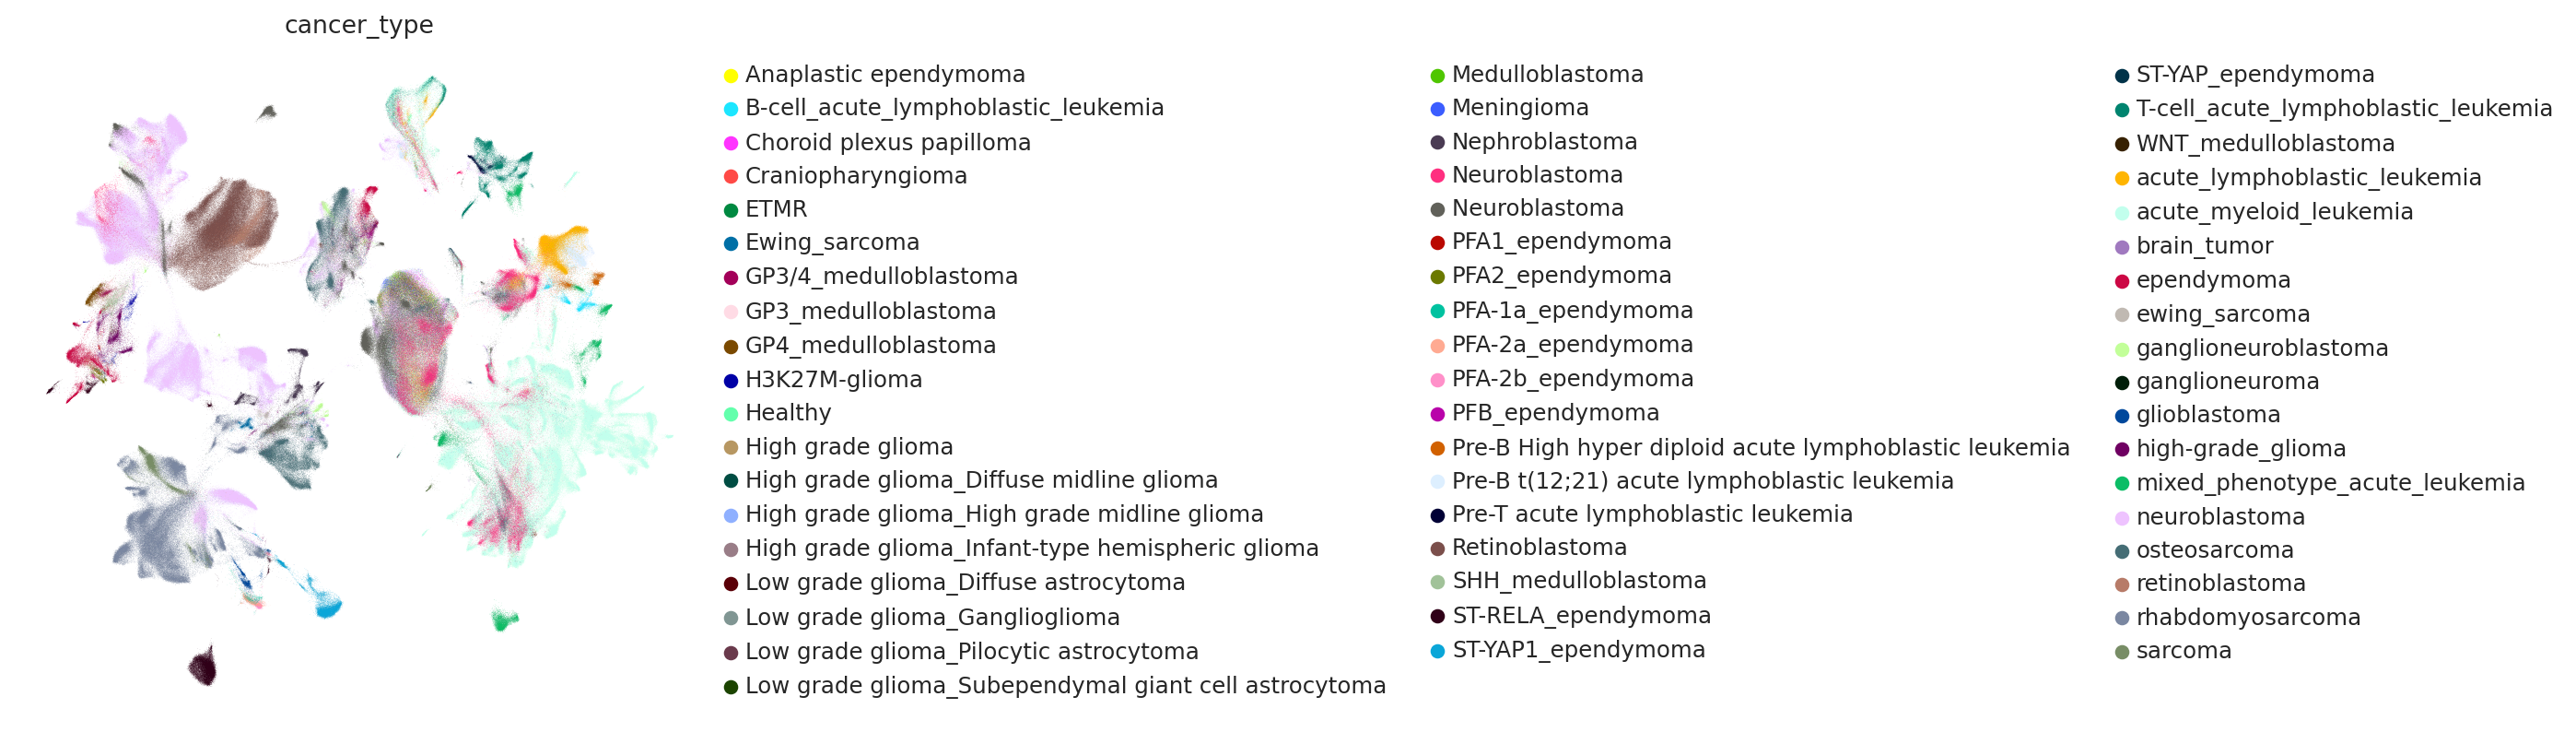

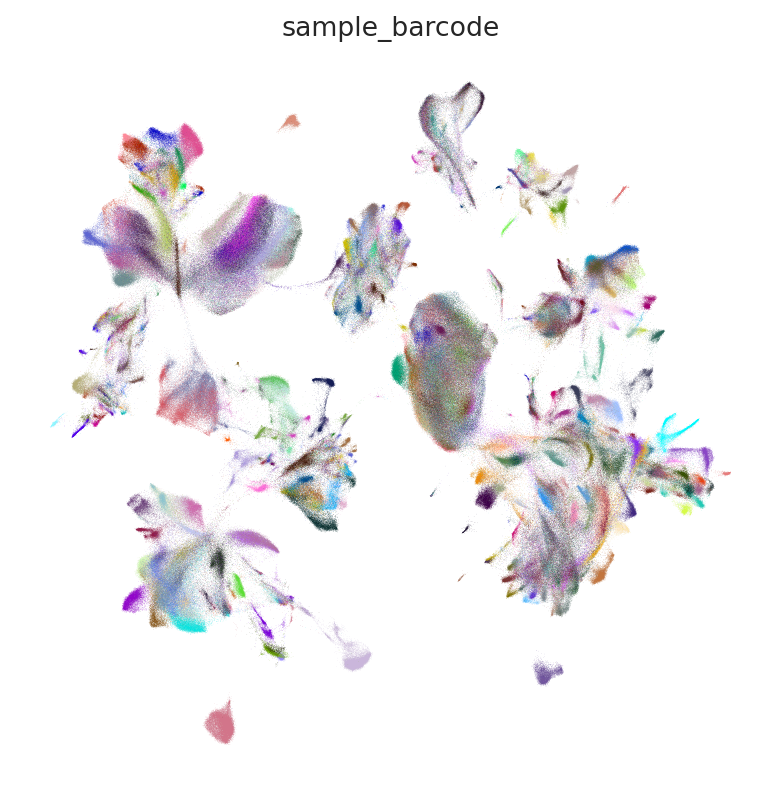

In [18]:
sc.pl.umap(
    meta_anndata_scVI,
    color=["cancer_type"],
    frameon=False,
)

sc.pl.umap(
    meta_anndata_scVI,
    color=["sample_barcode"],
    palette=glasbey.create_palette(palette_size=488), 
    frameon=False,
    legend_loc=None,
)

In [19]:
# Save the pca meta anndata (for faster plotting in the future)
meta_anndata_scVI.write_h5ad('/scratch/user/s4543064/Xiaohan_Summer_Research/write/08_all_cancer/all_cancer_meta_anndata_scVI_pca.h5ad', compression='gzip')

In [6]:
# Load the pca meta anndata
meta_anndata_scVI = sc.read_h5ad('/scratch/user/s4543064/Xiaohan_Summer_Research/write/08_all_cancer/all_cancer_meta_anndata_scVI_pca.h5ad')

In [7]:
# Visualization after integration
sc.pp.neighbors(meta_anndata_scVI, use_rep="X_scVI")
sc.tl.umap(meta_anndata_scVI, min_dist=0.3)

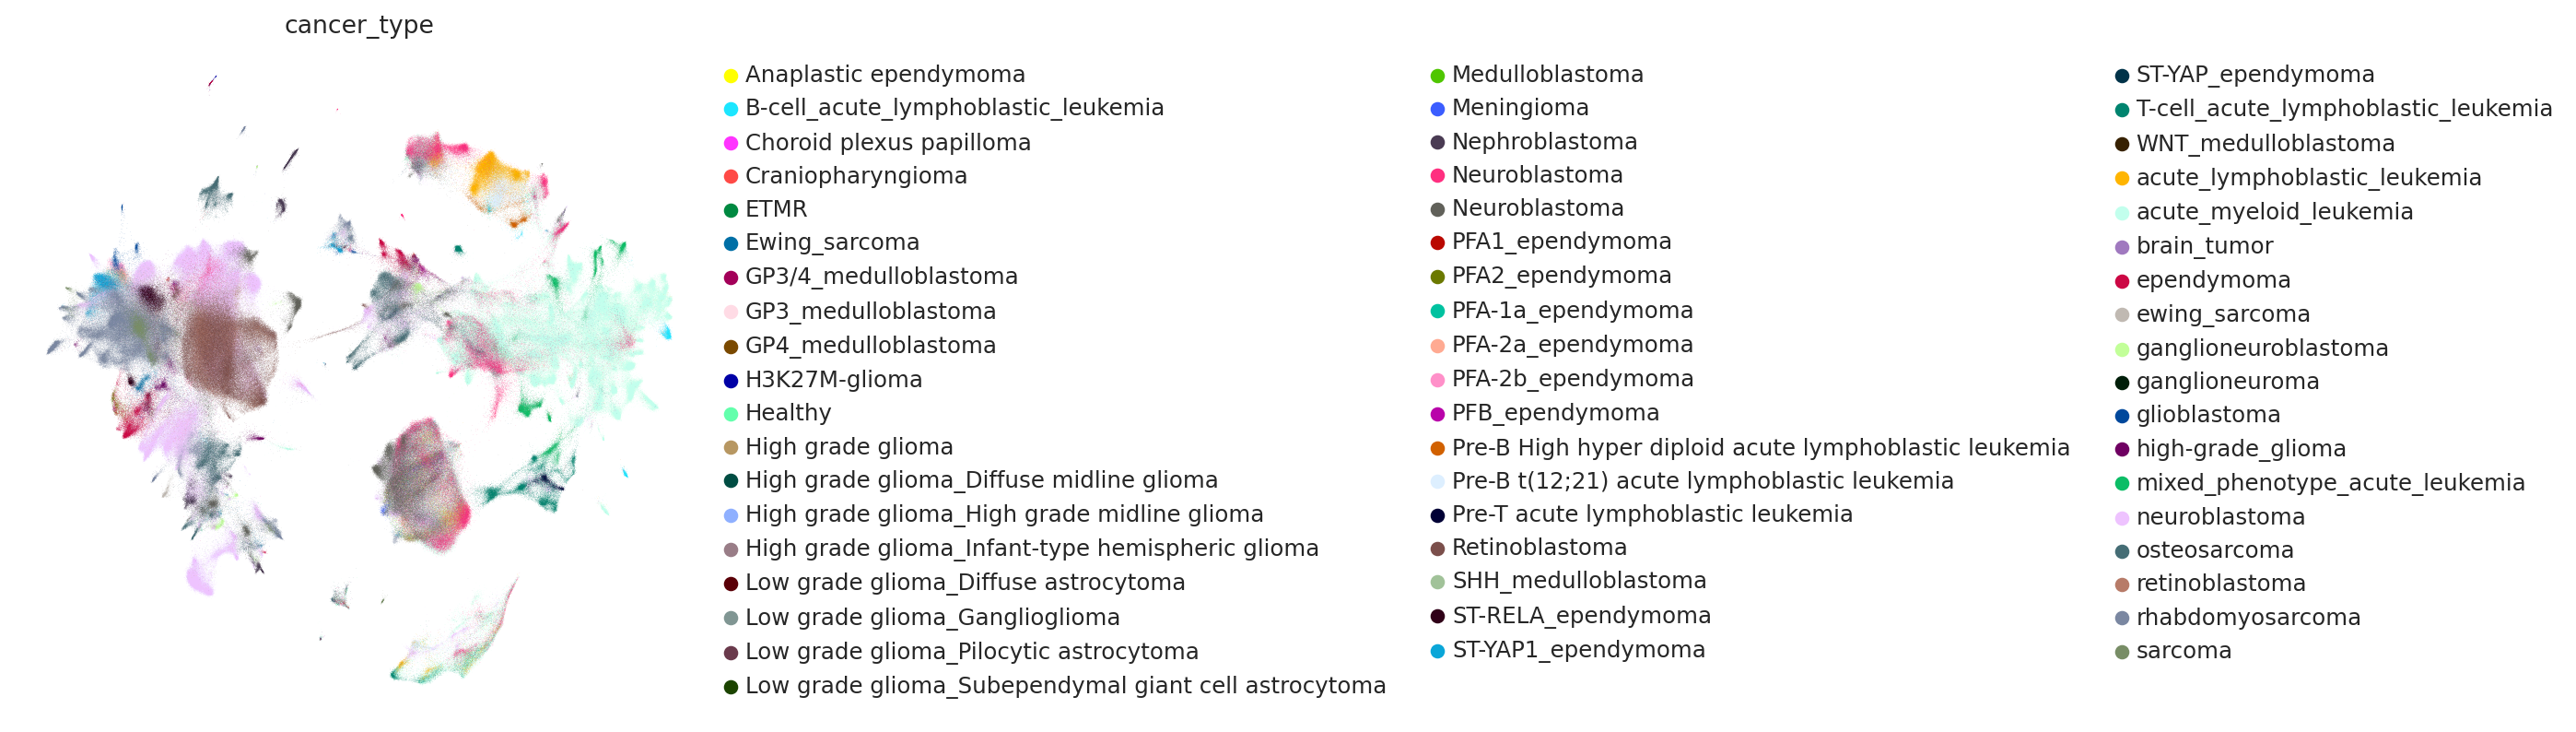

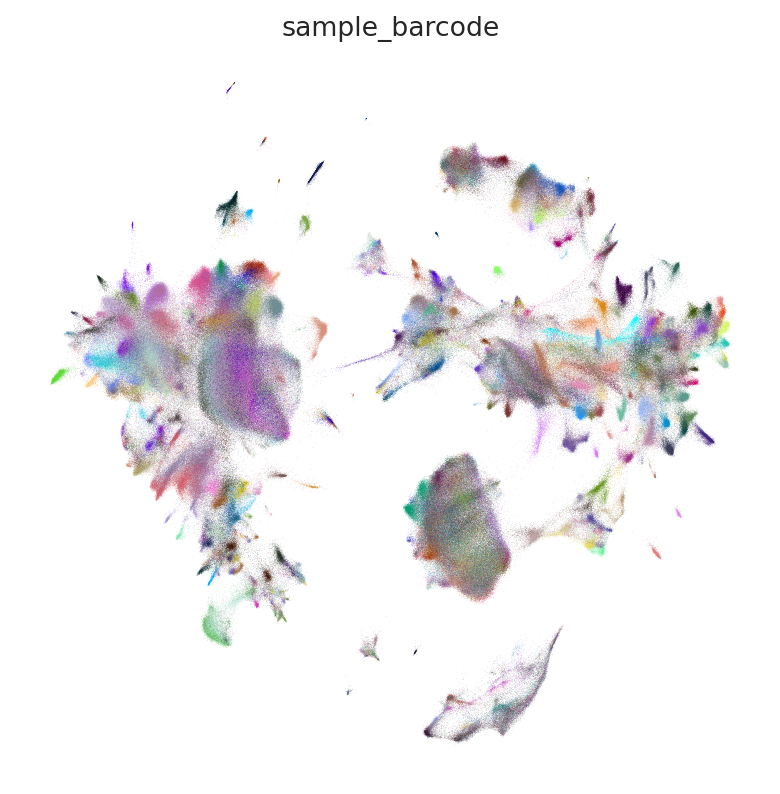

In [8]:
sc.pl.umap(
    meta_anndata_scVI,
    color=["cancer_type"],
    frameon=False,
)

sc.pl.umap(
    meta_anndata_scVI,
    color=["sample_barcode"],
    palette=glasbey.create_palette(palette_size=488), 
    frameon=False,
    legend_loc=None,
)

In [9]:
meta_anndata_scVI

AnnData object with n_obs × n_vars = 1300958 × 559
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'disease_progression', 'sample_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'filter_rna', 'cell_type_from_paper', 'malignant_from_paper', 'age_months', 'age', 'sex', 'recurrent', 'cancer_subtype', 'metastatic', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cancer_type_colors', 'hvg', 'neighbors', 'pca', 'sample_barcode_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
# Save the scVI-corrected meta anndata (for faster plotting in the future)
meta_anndata_scVI.write_h5ad('/scratch/user/s4543064/Xiaohan_Summer_Research/write/08_all_cancer/all_cancer_meta_anndata_scVI_umap.h5ad', compression='gzip')

In [11]:
# Cluster
sc.tl.leiden(meta_anndata_scVI, key_added="leiden_scVI", resolution=0.5)

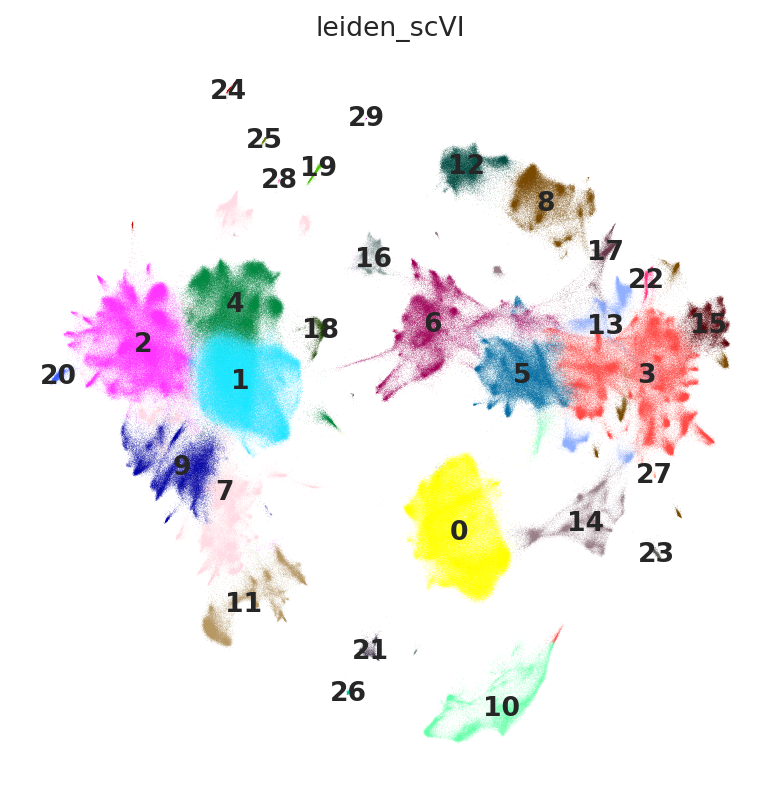

In [12]:
sc.pl.umap(
    meta_anndata_scVI,
    color=["leiden_scVI"],
    legend_loc="on data",
    frameon=False,
)

In [13]:
meta_anndata_scVI

AnnData object with n_obs × n_vars = 1300958 × 559
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'disease_progression', 'sample_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'filter_rna', 'cell_type_from_paper', 'malignant_from_paper', 'age_months', 'age', 'sex', 'recurrent', 'cancer_subtype', 'metastatic', '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cancer_type_colors', 'hvg', 'neighbors', 'pca', 'sample_barcode_colors', 'umap', 'leiden', 'leiden_scVI_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
# Save the clustered meta AnnData
meta_anndata_scVI.write_h5ad('/scratch/user/s4543064/Xiaohan_Summer_Research/write/08_all_cancer/all_cancer_meta_anndata_scVI_cluster.h5ad', compression='gzip')